<a href="https://colab.research.google.com/github/recognita/EIM-for-Muscle-Construction-Detection/blob/main/challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [1]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

Mounted at /gdrive
/gdrive/My Drive/AN2DL/challenge1


## ⚙️ **Libraries** **Import**

In [2]:
# Set seed for reproducibility

SEED = 42
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.stats import norm, ttest_ind
from scipy.signal import welch


from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python


# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


# =========================
# 1) Imports & helpers
# =========================
import os, math, random, copy, gc
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [3]:
# Set environment variables for dataset paths
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["TRAIN_URL"] = "1yRqrSB1JQwH09p1fXpO7lNfQZBl0PSBs"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["LABEL_URL"] = "1BhWWiWQeBt9R4BcenRjzuuO0-VKQV8oJ"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["TEST_URL"] = "1fXPfRottySriJF2uyRzpUgOI5affanMa"

# Check if Activity Recognition dataset exists and download if not
if not os.path.exists(os.environ["TRAIN_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TRAIN_URL} -O ${TRAIN_FILE}
    print("Activity Recognition dataset1 downloaded!")
else:
    print("Activity Recognition dataset1 already downloaded. Using cached data.")

if not os.path.exists(os.environ["LABEL_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${LABEL_URL} -O ${LABEL_FILE}
    print("Activity Recognition dataset2 downloaded!")
else:
    print("Activity Recognition dataset2 already downloaded. Using cached data.")

if not os.path.exists(os.environ["TEST_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TEST_URL} -O ${TEST_FILE}
    print("Activity Recognition dataset3 downloaded!")
else:
    print("Activity Recognition dataset3 already downloaded. Using cached data.")

Activity Recognition dataset1 already downloaded. Using cached data.
Activity Recognition dataset2 already downloaded. Using cached data.
Activity Recognition dataset3 already downloaded. Using cached data.


## 🔎 **Exploration and Data Analysis**


In [4]:
# Load the dataset from a CSV file
dataset_train = pd.read_csv('pirate_pain_train.csv')
dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
dataset_test = pd.read_csv('pirate_pain_test.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset_train.shape}")
print(f"Dataset shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset_train.head()
#661 is the number of people

Dataset shape: (105760, 40)
Dataset shape: (661, 2)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [ ]:

#Everyone did 160 seconds or 2 min
counts_per_sample = dataset_train.groupby('sample_index')['time'].count()
all_160_timesteps = (counts_per_sample == 160).all()
print(f"All subjects have 160 time steps: {all_160_timesteps}")

All subjects have 160 time steps: True


In [44]:
lengths = dataset_train_wd.groupby('sample_index').size()
print(lengths.describe())
T_min = int(lengths.min())
T_max = int(lengths.max())
print("Min length:", T_min, "Max length:", T_max)

count    661.0
mean     160.0
std        0.0
min      160.0
25%      160.0
50%      160.0
75%      160.0
max      160.0
dtype: float64
Min length: 160 Max length: 160


In [ ]:
print(dataset_train.isna().mean().sort_values(ascending=False).head(10))
print(dataset_train['sample_index'].nunique(), dataset_labels['sample_index'].nunique())

sample_index     0.0
time             0.0
pain_survey_1    0.0
pain_survey_2    0.0
pain_survey_3    0.0
pain_survey_4    0.0
n_legs           0.0
n_hands          0.0
n_eyes           0.0
joint_00         0.0
dtype: float64
661 661


- No missing values: All columns show a mean of 0.0 for null values, meaning the dataset is clean and doesn't require imputation or removal of NaNs.

- Subject count consistency: Both dataset_train and dataset_labels contain 661 unique sample_index entries, confirming alignment between features and labels.

dataset_train['sample_index'].nunique() = 661

dataset_labels['sample_index'].nunique() = 661

# Is it balance or imbalance?

In [ ]:
dataset_labels['label'].value_counts()

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [ ]:
dataset_labels['label'].value_counts(normalize=True)

,proportion
label,
no_pain,0.773071
low_pain,0.142209
high_pain,0.084720


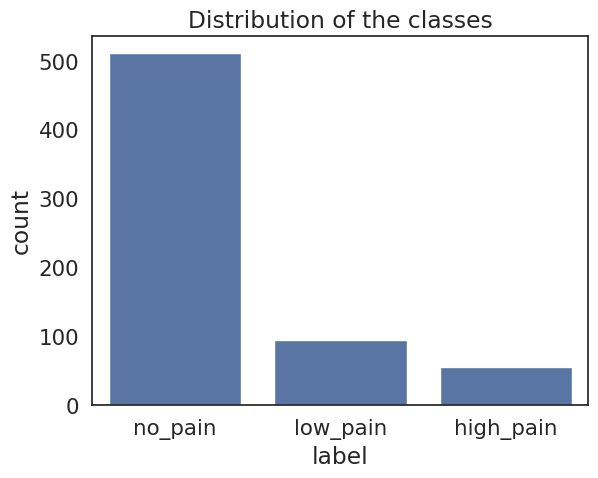

In [ ]:



sns.countplot(data=dataset_labels, x='label')
plt.title('Distribution of the classes')
plt.show()


Result: class imbalance, tend to no_pain

# Data cleaning


Plot inspection - see the kept-up average line

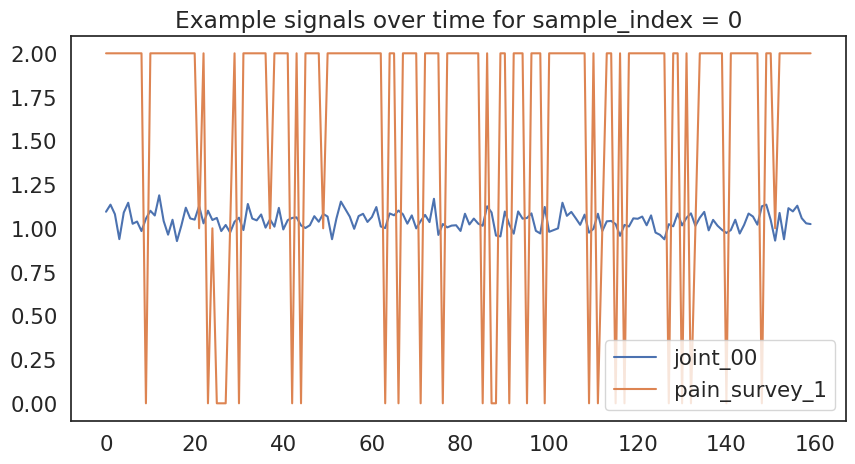

In [ ]:
subject = dataset_train[dataset_train['sample_index'] == 0]

plt.figure(figsize=(10,5))
plt.plot(subject['time'], subject['joint_00'], label='joint_00')
plt.plot(subject['time'], subject['pain_survey_1'], label='pain_survey_1')
plt.legend()
plt.title('Example signals over time for sample_index = 0')
plt.show()

Finding zero sensors:


In [ ]:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(dataset_train.select_dtypes(float))

low_var_cols = dataset_train.select_dtypes(float).columns[~selector.get_support()]
print("Low variance features:", low_var_cols.tolist())


Low variance features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30']


Finding sensors with unusually large or unstable values:

In [ ]:
stats = dataset_train.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std_over_mean'] = stats['std'] / stats['mean'].abs()

stats[['range', 'std_over_mean']].sort_values('std_over_mean', ascending=False).head(10)

,range,std_over_mean
joint_22,1.305001,131.015423
joint_21,1.442198,125.235102
joint_23,0.274241,34.686300
joint_25,0.947354,31.291376
joint_19,0.616061,20.430056
joint_20,1.096014,20.275951
joint_14,0.264232,18.363109
joint_18,0.728382,17.025618
joint_16,0.188807,15.010470
joint_13,0.073852,13.007174


The ones that we need to remove are:

['joint_13','joint_14', 'joint_15','joint_16','joint_18','joint_19','joint_20',
  'joint_21','joint_22','joint_23','joint_24','joint_25','joint_30']

Class imbalance

In [ ]:
classes = np.unique(dataset_labels['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)

{'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}


So then in the model training you use this:

class_weights_tensor = torch.tensor([class_weights[c] for c in classes], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Remove unnecessary or noisy features


In [ ]:
# List of noisy / unnecessary features
noisy_features = [
    'joint_13', 'joint_14', 'joint_15', 'joint_16',
    'joint_18', 'joint_19', 'joint_20', 'joint_21',
    'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'
]

# Remove them off the dataset
dataset_train_clean = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
dataset_test_clean  = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')

print("✅ Removed noisy features.")
print(f"Original dataset_train shape: {dataset_train.shape}")
print(f"Cleaned  dataset_train shape: {dataset_train_clean.shape}")
print(f"Original dataset_test shape:  {dataset_test.shape}")
print(f"Cleaned  dataset_test shape:  {dataset_test_clean.shape}")


✅ Removed noisy features.
Original dataset_train shape: (105760, 40)
Cleaned  dataset_train shape: (105760, 27)
Original dataset_test shape:  (211840, 40)
Cleaned  dataset_test shape:  (211840, 27)


Create dataset with "disability" column instead of "n_leg", "n_hands", n_eyes".

In [ ]:
# NEW copies of train and test sets with disability column
dataset_train_with_disability = dataset_train_clean.copy()
dataset_test_with_disability = dataset_test_clean.copy()

# Anything non-two (eyes, hands, legs)
def is_disabled(value): return value != 'two'

# Every row checks across n_legs, n_hands, n_eyes
dataset_train_with_disability['disability'] = dataset_train_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

dataset_test_with_disability['disability'] = dataset_test_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

    # Convert it to float before training?

# Drop the old columns
dataset_train_with_disability = dataset_train_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
dataset_test_with_disability = dataset_test_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

Display new disability set changes:

In [ ]:
print("Original columns:", dataset_train_clean.columns[:10])
print("New columns:", dataset_train_with_disability.columns[:10])
print("Number of disabled subjects entries:", dataset_train_with_disability['disability'].sum())
disabled_subjects = dataset_train_with_disability.groupby('sample_index')['disability'].max().sum()
print("Number of unique disabled subjects:", disabled_subjects)
print("Disabled subjects are this percentage (%) of the total subjects:", disabled_subjects/dataset_train['sample_index'].nunique()*100)
dataset_train_with_disability.head() # Disability column at the end

Original columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes',
       'joint_00'],
      dtype='object')
New columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02',
       'joint_03'],
      dtype='object')
Number of disabled subjects entries: 960
Number of unique disabled subjects: 6
Disabled subjects are this percentage (%) of the total subjects: 0.9077155824508321


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_09,joint_10,joint_11,joint_12,joint_17,joint_26,joint_27,joint_28,joint_29,disability
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,1.050142,0.529555,0.447370,1.091046,0.000000,0.017592,0.013508,0.026798,0.027815,0
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,1.060313,0.446810,0.414432,1.045862,0.000009,0.013352,0.000000,0.013377,0.013716,0
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,1.011410,0.432499,0.431535,1.088221,0.000000,0.016225,0.008110,0.024097,0.023105,0
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,1.047223,0.478806,0.420665,1.096832,0.000035,0.011832,0.007450,0.028613,0.024648,0
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,1.044731,0.452906,0.476537,1.103968,0.000000,0.005360,0.002532,0.033026,0.025328,0


# Training

Hyperparameters

In [ ]:
ENABLE_HAMPEL     = True      # робастное устранение выбросов
ENABLE_WINSORIZE  = True      # обрезка хвостов 0.5/99.5 перцентили
ENABLE_MEDIAN_HP  = False     # мягкий HPF: вычитание скользящей медианы
AUG_ENABLE        = True      # аугментации окна (train)
USE_FOCAL_LOSS    = True      # Focal Loss вместо CE
USE_FILM          = True      # FiLM-модуляция по disability
TTA_OFFSETS       = [0, 4, 8] # сдвиги стартов окон на тесте
WIN, STRIDE       = 32, 16    # базовый размер окна и шаг
BATCH             = 256
EPOCHS            = 20
# нормализация
DETREND   = True   # вычитание среднего по каналу (внутри sample)
RMS_NORM  = True   # деление на RMS по каналу (внутри sample)

# балансировка датасета равными частями по субъектам
EQUALIZE_SUBJECTS = False  # если True — берём одинаковое число sample_index на класс для train
MAX_WINDOWS_PER_SUBJECT = None  # например 200, чтобы длинные субъекты не доминировали по окнам

Functions for dataset preparation

In [9]:
def ensure_clean_datasets(dataset_train: pd.DataFrame,
                          dataset_labels: pd.DataFrame,
                          dataset_test: pd.DataFrame):
    noisy_features = [
        'joint_13','joint_14','joint_15','joint_16',
        'joint_18','joint_19','joint_20','joint_21',
        'joint_22','joint_23','joint_24','joint_25','joint_30'
    ]

    def add_disability(df: pd.DataFrame):
        df = df.copy()
        def is_disabled(v): return v != 'two'
        df['disability'] = df[['n_legs','n_hands','n_eyes']].apply(
            lambda row: any(is_disabled(x) for x in row), axis=1).astype(int)
        df = df.drop(columns=['n_legs','n_hands','n_eyes'])
        return df

    if 'dataset_train_with_disability' not in globals() or 'dataset_test_with_disability' not in globals():
        dtc = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
        dsc = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')
        dataset_train_wd = add_disability(dtc)
        dataset_test_wd  = add_disability(dsc)
    else:
        dataset_train_wd = globals()['dataset_train_with_disability'].copy()
        dataset_test_wd  = globals()['dataset_test_with_disability'].copy()

    # merge labels per sample
    labels_map = dataset_labels.set_index('sample_index')['label'].to_dict()
    return dataset_train_wd, dataset_test_wd, labels_map

# =========================
# 3) Windowed dataset with per-sample normalization + aug
# =========================
def hampel_filter_1d(x, k=5, n_sigmas=3.0):
    # скользящая медиана как оценка тренда, замена выбросов на медиану окна
    medf = x.copy()
    pad = np.pad(x, (k,k), mode='edge')
    for i in range(len(x)):
        win = pad[i:i+2*k+1]
        medf[i] = np.median(win)
    mad = np.median(np.abs(x - medf)) + 1e-8
    thr = n_sigmas * 1.4826 * mad
    out = x.copy()
    mask = np.abs(x - medf) > thr
    out[mask] = medf[mask]
    return out

def augment_window_torch(x: 'torch.Tensor'):
    # x: [C, T]
    if not AUG_ENABLE:
        return x
    if random.random() < 0.5:
        # амплитудный джиттер ±2%
        scale = 1.0 + 0.02*torch.randn(x.size(0), 1, device=x.device)
        x = x * scale
    if random.random() < 0.25:
        # time-mask коротким нулевым окном
        t = x.size(1)
        w = max(2, t//8)
        s = random.randint(0, max(0, t-w))
        x[:, s:s+w] = 0.0
    return x

Dataset

In [ ]:
class WindowedPirateDataset(Dataset):
    def __init__(self, df, feature_cols, labels_map=None, label_to_id=None,
                 sample_indices=None, window_size=100, stride=50,
                 is_test=False, train_mode=True, start_offset=0):
        self.df = df
        self.feature_cols = feature_cols
        self.labels_map = labels_map
        self.label_to_id = label_to_id
        self.sample_indices = sample_indices if sample_indices is not None else df['sample_index'].unique()
        self.window_size = window_size
        self.stride = stride
        self.is_test = is_test
        self.train_mode = train_mode
        self.start_offset = start_offset
        self.windows = self._build_windows()

    def _build_windows(self):
        windows = []
        for sid in self.sample_indices:
            sub = self.df[self.df['sample_index']==sid]
            for start in range(self.start_offset, len(sub)-self.window_size+1, self.stride):
                end = start + self.window_size
                windows.append((sid, start, end))
        return windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        sid, start, end = self.windows[idx]
        window = self.df[self.df['sample_index']==sid].iloc[start:end]

        # --- Features
        X = torch.tensor(window[self.feature_cols].values, dtype=torch.float32)  # [window_size, n_features]

        # --- Disability (scalar per sample, same for all timesteps)
        disability = torch.tensor(window['disability'].iloc[0], dtype=torch.long).unsqueeze(0)  # [1]

        # --- Label
        if not self.is_test:
            label = self.labels_map[sid] if self.labels_map is not None else window['label'].iloc[0]
            y = torch.tensor(self.label_to_id[label], dtype=torch.long)
        else:
            y = torch.tensor(-1)  # dummy for test

        return X, y, disability, sid


CNN

In [ ]:
class FiLM(nn.Module):
    def __init__(self, ch, emb_dim=8):
        super().__init__()
        self.emb = nn.Embedding(2, emb_dim)    # disability ∈ {0,1}
        self.to_gb = nn.Sequential(
            nn.Linear(emb_dim, 2*ch),
            nn.Tanh()
        )
    def forward(self, h, d):  # h: [B,C,T], d: [B]
        gb = self.to_gb(self.emb(d))           # [B, 2C]
        gamma, beta = gb.chunk(2, dim=1)
        gamma = gamma.unsqueeze(-1); beta = beta.unsqueeze(-1)
        return h * (1 + 0.1*gamma) + 0.1*beta

class CNN1D(nn.Module):
    def __init__(self, in_ch: int, n_classes: int = 3, base: int = 64, dropout: float = 0.4, use_film: bool = True):
        super().__init__()
        self.use_film = use_film
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_ch, base, kernel_size=5, padding=2),
            nn.BatchNorm1d(base), nn.ReLU(inplace=True),
            nn.Conv1d(base, base, kernel_size=3, padding=1),
            nn.BatchNorm1d(base), nn.ReLU(inplace=True),
        )
        if self.use_film:
            self.film = FiLM(base)
        self.conv2 = nn.Sequential(
            nn.Conv1d(base, base*2, kernel_size=5, padding=2, dilation=2),
            nn.BatchNorm1d(base*2), nn.ReLU(inplace=True),
            nn.Conv1d(base*2, base*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base*2), nn.ReLU(inplace=True),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(base*2, base),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(base, n_classes)
        )

    def forward(self, x, d=None):  # x: [B, C, T], d: [B]
        h = self.conv1(x)
        if self.use_film and d is not None:
            h = self.film(h, d)
        h = self.conv2(h)
        h = self.pool(h)
        return self.head(h)

Build

In [25]:

# =========================
# 5) Build everything & train
# =========================
# --- Load or ensure datasets
dataset_train_wd, dataset_test_wd, labels_map = ensure_clean_datasets(dataset_train, dataset_labels, dataset_test)

# feature columns: все числовые, кроме служебных
drop_cols = {'time','sample_index'}
all_num = dataset_train_wd.select_dtypes(include=[np.number]).columns.tolist()
# исключаем disability из каналов — подаем как контекст
feature_cols = [c for c in dataset_train_wd.columns if c not in drop_cols and c in all_num and c != 'disability']

# label mapping (fixed order)
ordered_labels = ['no_pain', 'low_pain', 'high_pain']
label_to_id = {y:i for i,y in enumerate(ordered_labels)}
id_to_label = {i:y for y,i in label_to_id.items()}

# split по субъектам (stratify по меткам)
sid_list = sorted(dataset_train_wd['sample_index'].unique().tolist())
y_per_sid = [labels_map[sid] for sid in sid_list]
train_sids, val_sids = train_test_split(
    sid_list, test_size=0.2, random_state=SEED, stratify=y_per_sid
)

# datasets
train_ds = WindowedPirateDataset(dataset_train_wd, feature_cols, labels_map, label_to_id,
                                 sample_indices=train_sids, window_size=WIN, stride=STRIDE,
                                 is_test=False, train_mode=True, start_offset=0)
def equalize_subjects_by_class(sids, labels_map, ordered_labels):
    # считаем сколько субъектов каждого класса
    per_class = {y: [] for y in ordered_labels}
    for sid in sids:
        per_class[labels_map[sid]].append(sid)
    # выбираем минимум по классам
    m = min(len(per_class[y]) for y in ordered_labels if len(per_class[y]) > 0)
    # если какой-то класс пуст, ничего не делаем
    if m == 0:
        return sids
    # undersampling до одного размера m по всем классам
    new_sids = []
    rng = np.random.default_rng(SEED)
    for y in ordered_labels:
        arr = per_class[y]
        if len(arr) >= m:
            picked = rng.choice(arr, size=m, replace=False)
        else:
            # если класс совсем маленький — можно дублировать (опционально)
            picked = rng.choice(arr, size=m, replace=True)
        new_sids.extend(picked.tolist())
    rng.shuffle(new_sids)
    return new_sids

if EQUALIZE_SUBJECTS:
    train_sids = equalize_subjects_by_class(train_sids, labels_map, ordered_labels)
val_ds   = WindowedPirateDataset(dataset_train_wd, feature_cols, labels_map, label_to_id,
                                 sample_indices=val_sids,   window_size=WIN, stride=STRIDE,
                                 is_test=False, train_mode=False, start_offset=0)
test_ds  = WindowedPirateDataset(dataset_test_wd,  feature_cols, None,       label_to_id,
                                 sample_indices=sorted(dataset_test_wd['sample_index'].unique()),
                                 window_size=WIN, stride=STRIDE, is_test=True, train_mode=False, start_offset=0)

# sampler с балансировкой окон по классам
train_labels = [train_ds.index[i][3] for i in range(len(train_ds))]
class_counts = Counter(train_labels)
num_classes = len(ordered_labels)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.arange(num_classes),
                                     y=np.array(train_labels))
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

sample_weights = [1.0 / class_counts[y] for y in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# loaders
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,    num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,    num_workers=0, pin_memory=True)

# model / loss / opt
model = CNN1D(in_ch=len(feature_cols), n_classes=num_classes, base=64, dropout=0.25, use_film=USE_FILM).to(device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce).clamp(min=1e-6, max=1-1e-6)
        return ((1-pt)**self.gamma) * ce

criterion = FocalLoss(weight=class_weights) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights)


# scheduler (optional)
steps_per_epoch = max(1, math.ceil(len(train_loader)))
scheduler = OneCycleLR(optimizer, max_lr=2e-3, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.15)

# =========================
# 6) Train & validate
# =========================
def run_epoch(loader, model, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []
    for batch in loader:
        X, y, d, _sid = batch
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        d = d.to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            logits = model(X, d)
            loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

        total_loss += loss.item() * X.size(0)
        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    return total_loss / len(loader.dataset), acc, f1m, all_true, all_pred

best_f1 = -1
best_state = None


for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(train_loader, model, train_mode=True)
    vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch(val_loader,   model, train_mode=False)
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} f1m={tr_f1:.4f} | "
          f"val: loss={vl_loss:.4f} acc={vl_acc:.4f} f1m={vl_f1:.4f}")

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        best_state = copy.deepcopy(model.state_dict())
        os.makedirs("models", exist_ok=True)
        torch.save({'state_dict': best_state, 'feature_cols': feature_cols,
                    'label_to_id': label_to_id, 'id_to_label': id_to_label,
                    'win': WIN, 'stride': STRIDE}, "models/best_cnn1d.pt")

print("\nValidation classification report:")
print(classification_report(y_true, y_pred, target_names=[id_to_label[i] for i in range(num_classes)], digits=4))

# load best for inference
if best_state is not None:
    model.load_state_dict(best_state)

# =========================
# 7) Inference on TEST with TTA (aggregate windows → per-sample)
# =========================
model.eval()
logits_per_sid: Dict[int, List[torch.Tensor]] = defaultdict(list)
with torch.no_grad():
    # базовый offset=0
    for X, d, sids in test_loader:
        X = X.to(device, non_blocking=True)
        d = d.to(device, non_blocking=True)
        logits = model(X, d).detach().cpu()
        for sid, logit in zip(sids.tolist(), logits):
            logits_per_sid[sid].append(logit)
    # доп. смещения
    for off in TTA_OFFSETS:
        if off == 0:
            continue
        tta_ds  = WindowedPirateDataset(dataset_test_wd, feature_cols, None, label_to_id,
                                        sample_indices=sorted(dataset_test_wd['sample_index'].unique()),
                                        window_size=WIN, stride=STRIDE, is_test=True, train_mode=False, start_offset=off)
        tta_dl  = DataLoader(tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
        for X, d, sids in tta_dl:
            X = X.to(device, non_blocking=True)
            d = d.to(device, non_blocking=True)
            logits = model(X, d).detach().cpu()
            for sid, logit in zip(sids.tolist(), logits):
                logits_per_sid[sid].append(logit)

pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)        # [n_windows_total, n_classes]
    mean_logits = L.mean(dim=0)           # усредняем окна и сдвиги
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

submission = pd.DataFrame(pred_rows)
os.makedirs("models", exist_ok=True)
sub_path = "models/submission_cnn1d.csv"
submission.to_csv(sub_path, index=False)
print(f"\nSaved submission to: {sub_path}")
submission.head()


NameError: name 'EQUALIZE_SUBJECTS' is not defined

# Start of BiGRU setup

In [ ]:
#FiLM with vectors
class FiLMVec(nn.Module):
    """
    FiLM conditioning for vectors
    Disability (0/1) -> gamma, beta applied element-wise to a vector.
    """
    def __init__(self, vec_dim, emb_dim=8):
        super().__init__()
        self.emb = nn.Embedding(2, emb_dim)  # disability ∈ {0,1}
        self.to_gb = nn.Sequential(
            nn.Linear(emb_dim, 2*vec_dim),
            nn.Tanh()
        )

    def forward(self, v, d):
        # v: [B, D]
        # d: [B] or [B,1] (long)
        d = d.squeeze(-1)          # ensure d is [B]
        gb = self.to_gb(self.emb(d))  # [B, 2*D]
        gamma, beta = gb.chunk(2, dim=1)  # [B, D], [B, D]
        return v * (1 + 0.1 * gamma) + 0.1 * beta


General RecurrentClassifier

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Recurrent classifier supporting RNN/LSTM/GRU, bidirectional,
    optional FiLM conditioning on disability, and optional pooling fusion.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU' -> still to fully implement
            bidirectional=False,
            dropout_rate=0.2,
            use_film: bool = False,
            use_pooling: bool = False
            ):
        super().__init__()

        self.rnn_type = rnn_type.upper()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.use_film = use_film
        self.use_pooling = use_pooling

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        if self.rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[self.rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0.0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # compute classifier input dimension
        base_dim = hidden_size * (2 if bidirectional else 1)
        if self.use_pooling:
            classifier_input_size = base_dim + base_dim  # concat last_hidden + mean_pool
        else:
            classifier_input_size = base_dim

        if self.use_film:
            self.film = FiLMVec(classifier_input_size, emb_dim=8)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, num_classes)
        )

    def forward(self, x, disability=None):
        """
        x: [B, seq_len, features]
        disability: [B] (long) or None. If provided and use_film True, it's used.
        returns logits: [B, num_classes]
        """
        # rnn_out: [B, seq_len, hidden * num_directions]
        rnn_out, hidden = self.rnn(x)

        # for LSTM, hidden is (h_n, c_n)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # take h_n

        # hidden: (num_layers * num_dirs, B, hidden)
        if self.bidirectional:
            # reshape -> (num_layers, num_dirs, batch, hidden)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # last layer forward & backward
            fwd = hidden[-1, 0, :, :]  # [B, hidden]
            bwd = hidden[-1, 1, :, :]
            last_hidden = torch.cat([fwd, bwd], dim=1)  # [B, hidden*2]
        else:
            last_hidden = hidden[-1]  # [B, hidden]

        if self.use_pooling:
            pooled = rnn_out.mean(dim=1)  # [B, hidden*dirs]
            feat = torch.cat([last_hidden, pooled], dim=1)
        else:
            feat = last_hidden  # [B, classifier_input_size]

        if self.use_film and (disability is not None):
            feat = self.film(feat, disability)

        logits = self.classifier(feat)
        return logits


Run epoch function for rnn

In [ ]:
def run_epoch_rnn(loader, model, optimizer=None, scheduler=None, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []

    for X, y, disability, sids in loader:
        X = X.to(device)
        y = y.to(device)
        disability = disability.to(device)

        logits = model(X, disability)  # [B, num_classes]
        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)  # sum over batch

        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, acc, f1m, all_true, all_pred


BiGRU

In [ ]:
# --- Load or ensure datasets
dataset_train_wd, dataset_test_wd, labels_map = ensure_clean_datasets(dataset_train, dataset_labels, dataset_test)

# --- Merge labels into training set
# labels_map is assumed to be a dict {sample_index: label}
labels_df = pd.DataFrame(list(labels_map.items()), columns=['sample_index', 'label'])
dataset_train_wd = dataset_train_wd.merge(labels_df, on='sample_index', how='left')

# Sanity check
print("Columns after merge:", dataset_train_wd.columns.tolist())
print(dataset_train_wd[['sample_index', 'label']].head())

# --- Define numeric feature columns (excluding service columns + disability)
drop_cols = {'time', 'sample_index', 'label', 'disability'}
all_num = dataset_train_wd.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in all_num if c not in drop_cols]

print(f"Using {len(feature_cols)} numeric feature columns (excluding disability):")
print(feature_cols[:10], "...")

# --- Define label mappings
label_to_id = {lbl: idx for idx, lbl in enumerate(sorted(dataset_train_wd['label'].unique()))}
id_to_label = {idx: lbl for lbl, idx in label_to_id.items()}
num_classes = len(label_to_id)
print(f"Classes: {num_classes} — {label_to_id}")


# Extract all sample IDs from your training set
all_sids = sorted(dataset_train_wd['sample_index'].unique())

# Each sample_index has one label — take it from the first occurrence
sample_labels = (
    dataset_train_wd.groupby('sample_index')['label']
    .first()
    .reindex(all_sids)
)

# Split into train and validation sample indices
train_sids, val_sids = train_test_split(
    all_sids, test_size=0.2, random_state=42, stratify=sample_labels
)

print(f"Train samples: {len(train_sids)}, Validation samples: {len(val_sids)}")



# Create dataloaders

# For training/validation, pass the labels_map dict
train_ds = WindowedPirateDataset(
    dataset_train_wd, feature_cols, labels_map, label_to_id,
    window_size=WIN, stride=STRIDE, train_mode=True
)
# Fix undefined validation dataset
val_ds = WindowedPirateDataset(
    dataset_train_wd,
    feature_cols,
    labels_map,
    label_to_id,
    sample_indices=val_sids,
    window_size=WIN,
    stride=STRIDE,
    train_mode=False
)

# For test set, labels_map=None since no ground truth
test_ds = WindowedPirateDataset(
    dataset_test_wd, feature_cols, None, label_to_id,
    window_size=WIN, stride=STRIDE, is_test=True
)


train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


# Hyperparams for BiGRU
HIDDEN_SIZE = 128
HIDDEN_LAYERS = 2
DROPOUT_RATE = 0.25
RNN_TYPE = 'GRU'
BIDIRECTIONAL = True
USE_FiLM = True           # enable disability
USE_POOLING = True
LEARNING_RATE = 2e-3
WEIGHT_DECAY = 1e-2
EPOCHS = 60
BATCH = 256

# model creation
rnn_model = RecurrentClassifier(
    input_size=len(feature_cols),
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE,
    use_film=True,
    use_pooling=USE_POOLING
).to(device)


# Optimizer and scheduler
optimizer = AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, math.ceil(len(train_loader)))
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.15)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)
    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce).clamp(min=1e-6, max=1-1e-6)
        return ((1-pt)**self.gamma) * ce


class_weights_tensor = torch.tensor(
    [class_weights[label] for label in sorted(label_to_id.keys())],
    dtype=torch.float32,
    device=device
)

criterion = FocalLoss(weight=class_weights_tensor) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Class weights tensor:", class_weights_tensor)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))


best_f1 = -1
best_state = None

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_rnn(train_loader, rnn_model, optimizer=optimizer, scheduler=scheduler, train_mode=True)
    vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(val_loader,   rnn_model, optimizer=None, scheduler=None, train_mode=False)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} f1m={tr_f1:.4f} | "
          f"val:   loss={vl_loss:.4f} acc={vl_acc:.4f} f1m={vl_f1:.4f}")

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        best_state = copy.deepcopy(rnn_model.state_dict())
        os.makedirs("models", exist_ok=True)
        torch.save({'state_dict': best_state, 'feature_cols': feature_cols,
                    'label_to_id': label_to_id, 'id_to_label': id_to_label,
                    'win': WIN, 'stride': STRIDE}, "models/best_bigru.pt")

###
# Load best validation model
if best_state is not None:
    rnn_model.load_state_dict(best_state)

# Re-run validation to get predictions from best model
vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(
    val_loader, rnn_model, optimizer=None, scheduler=None, train_mode=False
)

print("\nValidation classification report (best model):")
print(classification_report(
    y_true, y_pred,
    target_names=[id_to_label[i] for i in range(num_classes)],
    digits=4
))
###


rnn_model.eval()
logits_per_sid = defaultdict(list)
with torch.no_grad():
    for X, _, d, sids in test_loader:
      #X = X.permute(0, 2, 1).contiguous().to(device)
      X = X.to(device)
      d = d.to(device)
      logits = rnn_model(X, d).detach().cpu()
      for sid, logit in zip(sids.tolist(), logits):
          logits_per_sid[sid].append(logit)

    # TTA offsets
    for off in TTA_OFFSETS:
        if off == 0:
            continue
        tta_ds  = WindowedPirateDataset(dataset_test_wd, feature_cols, None, label_to_id,
                                        sample_indices=sorted(dataset_test_wd['sample_index'].unique()),
                                        window_size=WIN, stride=STRIDE, is_test=True, train_mode=False, start_offset=off)
        tta_dl  = DataLoader(tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
        for X, _, d, sids in tta_dl:
          X = X.to(device)  # no permute if shape is (batch, seq_len, features)
          d = d.to(device)
          logits = rnn_model(X, d).detach().cpu()
          for sid, logit in zip(sids.tolist(), logits):
              logits_per_sid[sid].append(logit)

# aggregate and build submission
pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)        # [n_windows_total, n_classes]
    mean_logits = L.mean(dim=0)
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

submission = pd.DataFrame(pred_rows)
submission.to_csv("models/submission_bigru.csv", index=False)
print("Saved submission to models/submission_bigru.csv")


Columns after merge: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_17', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'disability', 'label']
   sample_index    label
0             0  no_pain
1             0  no_pain
2             0  no_pain
3             0  no_pain
4             0  no_pain
Using 22 numeric feature columns (excluding disability):
['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05'] ...
Classes: 3 — {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Train samples: 528, Validation samples: 133
Class weights tensor: tensor([3.9345, 2.3440, 0.4312])
[01/100] train: loss=0.4821 acc=0.5125 f1m=0.3448 | val:   loss=0.4666 acc=0.4695 f1m=0.4176
[02/100] train: loss=0.4610 acc=0.5566 f1m=0

KeyboardInterrupt: 

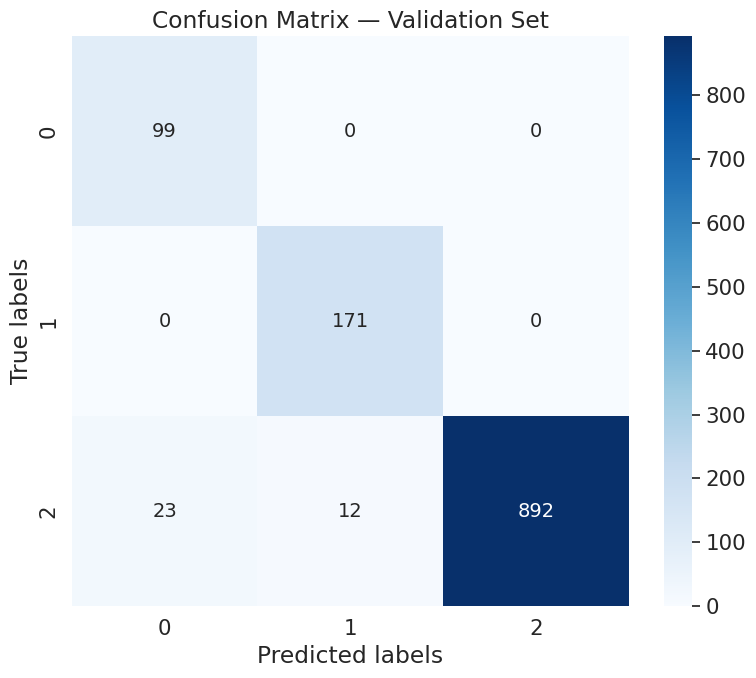

In [ ]:
# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(y_true, y_pred)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

##**BiGRU** with ANOTHER DATA

In [15]:
class FiLMVec(nn.Module):
    """
    FiLM conditioning for vectors
    Disability (0/1) -> gamma, beta applied element-wise to a vector.
    """
    def __init__(self, vec_dim, emb_dim=8):
        super().__init__()
        self.emb = nn.Embedding(2, emb_dim)  # disability ∈ {0,1}
        self.to_gb = nn.Sequential(
            nn.Linear(emb_dim, 2*vec_dim),
            nn.Tanh()
        )

    def forward(self, v, d):
        # v: [B, D]
        # d: [B] or [B,1] (long)
        d = d.squeeze(-1)              # ensure d is [B]
        gb = self.to_gb(self.emb(d))   # [B, 2*D]
        gamma, beta = gb.chunk(2, dim=1)  # [B, D], [B, D]
        return v * (1 + 0.1 * gamma) + 0.1 * beta


In [16]:
class RecurrentClassifier(nn.Module):
    """
    Recurrent classifier supporting RNN/LSTM/GRU, bidirectional,
    optional FiLM conditioning on disability, and optional pooling fusion.

    Теперь вход:
      - seq: [B, C, T]  (C каналов, T временных шагов)
      - vec: [B, X]     (доп. вектор признаков)
    """
    def __init__(
            self,
            seq_channels,        # C — число каналов (фич на шаг)
            vec_dim,             # X — размер дополнительного вектора
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',      # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.4,
            use_film: bool = False,
            use_pooling: bool = False
        ):
        super().__init__()

        self.rnn_type     = rnn_type.upper()
        self.num_layers   = num_layers
        self.hidden_size  = hidden_size
        self.bidirectional = bidirectional
        self.use_film     = use_film
        self.use_pooling  = use_pooling
        self.seq_channels = seq_channels
        self.vec_dim      = vec_dim

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
        if self.rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[self.rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0.0

        # RNN ожидает [B, T, features]
        self.rnn = rnn_module(
            input_size=seq_channels,     # C
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # базовая размерность rnn-фичей
        base_dim = hidden_size * (2 if bidirectional else 1)
        if self.use_pooling:
            rnn_feat_dim = base_dim + base_dim   # last_hidden + mean_pool
        else:
            rnn_feat_dim = base_dim

        # добавляем вектор признаков размера vec_dim
        classifier_input_size = rnn_feat_dim + vec_dim

        if self.use_film:
            self.film = FiLMVec(classifier_input_size, emb_dim=8)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_input_size, num_classes)
        )

    def forward(self, seq, vec, disability=None):
        """
        seq: [B, C, T] или [B, T, C]
        vec: [B, X] или [B, 1, X]
        disability: [B] (long) или None
        returns: logits [B, num_classes]
        """

        # --- приведение seq к формату [B, T, C] ---
        if seq.dim() != 3:
            raise ValueError(f"seq must be 3D, got shape {seq.shape}")

        B, d1, d2 = seq.shape
        # Пытаемся угадать, где каналы
        # вариант 1: [B, C, T] (то, что ты просила) → транспонируем
        if d1 == self.seq_channels:
            seq = seq.transpose(1, 2)  # [B, T, C]
        # вариант 2: уже [B, T, C]
        elif d2 == self.seq_channels:
            # уже в нужном формате
            pass
        else:
            raise ValueError(
                f"Не могу сопоставить размер каналов: "
                f"ожидалось {self.seq_channels}, а имеем seq.shape={seq.shape}"
            )

        # --- приведение vec к [B, X] ---
        if vec.dim() == 3 and vec.size(1) == 1:
            vec = vec.squeeze(1)   # [B, X]
        if vec.dim() != 2:
            raise ValueError(f"vec must be [B, X] or [B,1,X], got {vec.shape}")
        if vec.size(1) != self.vec_dim:
            raise ValueError(
                f"vec_dim mismatch: expected {self.vec_dim}, got {vec.size(1)}"
            )

        # --- прогон через RNN ---
        # rnn_out: [B, T, hidden * num_dirs]
        rnn_out, hidden = self.rnn(seq)

        # for LSTM, hidden is (h_n, c_n)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # take h_n

        # hidden: (num_layers * num_dirs, B, hidden)
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # last layer forward & backward
            fwd = hidden[-1, 0, :, :]  # [B, hidden]
            bwd = hidden[-1, 1, :, :]  # [B, hidden]
            last_hidden = torch.cat([fwd, bwd], dim=1)  # [B, hidden*2]
        else:
            last_hidden = hidden[-1]  # [B, hidden]

        if self.use_pooling:
            pooled = rnn_out.mean(dim=1)  # [B, hidden*dirs]
            rnn_feat = torch.cat([last_hidden, pooled], dim=1)
        else:
            rnn_feat = last_hidden  # [B, rnn_feat_dim]

        # --- склейка с дополнительным вектором ---
        feat = torch.cat([rnn_feat, vec], dim=1)  # [B, rnn_feat_dim + vec_dim]

        # --- FiLM по disability (если включен) ---
        if self.use_film and (disability is not None):
            feat = self.film(feat, disability)

        logits = self.classifier(feat)
        return logits

In [17]:
def run_epoch_rnn(loader, model, optimizer=None, scheduler=None, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []

    for X_seq, X_vec, y, disability, sids in loader:
        X_seq = X_seq.to(device)
        X_vec = X_vec.to(device)
        y = y.to(device)
        disability = disability.to(device)

        logits = model(X_seq, X_vec, disability)

        # базовый loss (CE или Focal)
        base_loss = criterion(logits, y)

        # ---- L1 регуляризация ----
        l1_penalty = 0.0
        for name, param in model.named_parameters():
            if "weight" in name and param.requires_grad:
                l1_penalty = l1_penalty + param.abs().sum()
        loss = base_loss + L1_LAMBDA * l1_penalty
        # ---------------------------

        total_loss += loss.item() * X_seq.size(0)

        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, acc, f1m, all_true, all_pred


In [50]:
class WindowedPirateDataset(Dataset):
    """
    Windowed dataset with two inputs:
        X_seq: [T, C]
        X_vec: [X]
    and disability scalar, sid.
    """
    def __init__(
        self,
        df,
        seq_feature_cols,
        labels_map=None,
        label_to_id=None,
        sample_indices=None,
        window_size=100,
        stride=50,
        is_test=False,
        train_mode=True,
        start_offset=0,
        static_df=None,
        vec_feature_cols=None
    ):
        self.df = df
        self.seq_feature_cols = seq_feature_cols
        self.labels_map = labels_map
        self.label_to_id = label_to_id
        self.window_size = window_size
        self.stride = stride
        self.is_test = is_test
        self.train_mode = train_mode
        self.start_offset = start_offset

        self.static_df = static_df
        self.vec_feature_cols = vec_feature_cols or []

        if sample_indices is None:
            self.sample_indices = sorted(df['sample_index'].unique())
        else:
            self.sample_indices = list(sample_indices)

        self.windows = self._build_windows()

    def _build_windows(self):
        windows = []
        for sid in self.sample_indices:
            df_sid = self.df[self.df['sample_index'] == sid]
            T = len(df_sid)

            start = self.start_offset
            while start + self.window_size <= T:
                windows.append((sid, start, start + self.window_size))
                start += self.stride

        return windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        sid, start, end = self.windows[idx]

        df_sid = self.df[self.df['sample_index'] == sid]
        window = df_sid.iloc[start:end]

        # Sequence input
        X_seq = torch.tensor(
            window[self.seq_feature_cols].values,
            dtype=torch.float32
        )

        # Static vector
        if self.static_df is not None:
            row = self.static_df.loc[sid, self.vec_feature_cols]
            X_vec = torch.tensor(row.values, dtype=torch.float32)
        else:
            X_vec = torch.zeros(len(self.vec_feature_cols), dtype=torch.float32)

        # disability scalar
        if self.static_df is not None and "disability" in self.static_df.columns:
            dis_val = int(self.static_df.loc[sid, "disability"])
        else:
            dis_val = 0
        disability = torch.tensor(dis_val, dtype=torch.long)

        if self.is_test:
            # ONLY 4 values for test
            return X_seq, X_vec, disability, sid
        else:
            label_str = self.labels_map[sid]
            y = torch.tensor(self.label_to_id[label_str], dtype=torch.long)
            return X_seq, X_vec, y, disability, sid



In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

all_labels = dataset_train_wd['label']
classes = sorted(label_to_id.keys())

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(classes),
    y=all_labels
)

class_weights = {cls: w for cls, w in zip(classes, weights)}
print("Class weights:", class_weights)


Class weights: {'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}


In [52]:
# Автоматический выбор окна
T_min = int(lengths.min())

# хотим окно примерно 60–70% от минимальной длины, но не больше 150
WIN = min(150, max(40, int(T_min * 0.7)))
STRIDE = WIN // 2

print(f"Using WIN={WIN}, STRIDE={STRIDE}")
BATCH = 32
USE_FOCAL_LOSS = True

# --- Load or ensure datasets
dataset_train_wd, dataset_test_wd, labels_map = ensure_clean_datasets(dataset_train, dataset_labels, dataset_test)

# --- Merge labels into training set
# labels_map is assumed to be a dict {sample_index: label}
labels_df = pd.DataFrame(list(labels_map.items()), columns=['sample_index', 'label'])
dataset_train_wd = dataset_train_wd.merge(labels_df, on='sample_index', how='left')

# Sanity check
print("Columns after merge:", dataset_train_wd.columns.tolist())
print(dataset_train_wd[['sample_index', 'label']].head())

# --- какие колонки считаем статическими (отдельный вход 1xX)
static_cols = ['disability',
               'pain_survey_1', 'pain_survey_2',
               'pain_survey_3', 'pain_survey_4']

# --- фичи для временного ряда (CxT)
drop_cols = {'time', 'sample_index', 'label', *static_cols}
all_num = dataset_train_wd.select_dtypes(include=[np.number]).columns.tolist()
seq_feature_cols = [c for c in all_num if c not in drop_cols]

print(f"Seq features (for CxT): {len(seq_feature_cols)}")
print(seq_feature_cols[:10], "...")

# --- фичи для вектора (1xX)
vec_feature_cols = static_cols
print(f"Vec features (static): {vec_feature_cols}")

print(f"Using {len(seq_feature_cols)} numeric feature columns (excluding static cols):")
print(seq_feature_cols[:10], "...")

# --- фичи для вектора (1xX)
vec_feature_cols = static_cols
print(f"Vec features (static): {vec_feature_cols}")

print(f"Using {len(seq_feature_cols)} numeric feature columns (excluding disability & pain_survey):")
print(seq_feature_cols[:10], "...")

# --- статические признаки по sample_index (disability, pain_survey)
static_train = (
    dataset_train_wd[['sample_index'] + vec_feature_cols]
    .drop_duplicates('sample_index')
    .set_index('sample_index')
)

static_test = (
    dataset_test_wd[['sample_index'] + vec_feature_cols]
    .drop_duplicates('sample_index')
    .set_index('sample_index')
)

# --- Define label mappings
label_to_id = {lbl: idx for idx, lbl in enumerate(sorted(dataset_train_wd['label'].unique()))}
id_to_label = {idx: lbl for lbl, idx in label_to_id.items()}
num_classes = len(label_to_id)
print(f"Classes: {num_classes} — {label_to_id}")

# Extract all sample IDs from your training set
all_sids = sorted(dataset_train_wd['sample_index'].unique())

# Each sample_index has one label — take it from the first occurrence
sample_labels = (
    dataset_train_wd.groupby('sample_index')['label']
    .first()
    .reindex(all_sids)
)

# Split into train and validation sample indices
train_sids, val_sids = train_test_split(
    all_sids, test_size=0.2, random_state=42, stratify=sample_labels
)

print(f"Train samples: {len(train_sids)}, Validation samples: {len(val_sids)}")
# Create datasets

train_ds = WindowedPirateDataset(
    df=dataset_train_wd,
    seq_feature_cols=seq_feature_cols,
    labels_map=labels_map,
    label_to_id=label_to_id,
    sample_indices=train_sids,
    window_size=WIN,
    stride=STRIDE,
    is_test=False,
    train_mode=True,
    start_offset=0,
    static_df=static_train,
    vec_feature_cols=vec_feature_cols,
)

val_ds = WindowedPirateDataset(
    df=dataset_train_wd,
    seq_feature_cols=seq_feature_cols,
    labels_map=labels_map,
    label_to_id=label_to_id,
    sample_indices=val_sids,
    window_size=WIN,
    stride=STRIDE,
    is_test=False,
    train_mode=False,
    start_offset=0,
    static_df=static_train,
    vec_feature_cols=vec_feature_cols,
)

test_ds = WindowedPirateDataset(
    df=dataset_test_wd,
    seq_feature_cols=seq_feature_cols,
    labels_map=None,
    label_to_id=label_to_id,
    sample_indices=None,  # все sample_index в тесте
    window_size=WIN,
    stride=STRIDE,
    is_test=True,
    train_mode=False,
    start_offset=0,
    static_df=static_test,
    vec_feature_cols=vec_feature_cols,
)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
# Hyperparams for BiGRU
HIDDEN_SIZE   = 128
HIDDEN_LAYERS = 2
DROPOUT_RATE  = 0.25
RNN_TYPE      = 'GRU'
BIDIRECTIONAL = True
USE_FiLM      = True           # enable disability FiLM
USE_POOLING   = True
LEARNING_RATE = 2e-2
WEIGHT_DECAY  = 1e-2
EPOCHS        = 60


# model creation
rnn_model = RecurrentClassifier(
    seq_channels=len(seq_feature_cols),   # C
    vec_dim=len(vec_feature_cols),        # X (disability + pain_survey)
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE,
    use_film=USE_FiLM,
    use_pooling=USE_POOLING
).to(device)

# Optimizer and scheduler
optimizer = AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_loader))
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.15
)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, target):
        ce = self.ce(logits, target)
        pt = torch.exp(-ce).clamp(min=1e-6, max=1-1e-6)
        return ((1-pt)**self.gamma) * ce

class_weights_tensor = torch.tensor(
    [class_weights[label] for label in sorted(label_to_id.keys())],
    dtype=torch.float32,
    device=device
)
criterion = FocalLoss(weight=class_weights_tensor) if USE_FOCAL_LOSS else nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Class weights tensor:", class_weights_tensor)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
def run_epoch_rnn(loader, model, optimizer=None, scheduler=None, train_mode=True):
    model.train(train_mode)
    total_loss = 0.0
    all_pred, all_true = [], []

    for X_seq, X_vec, y, disability, sids in loader:
        X_seq = X_seq.to(device)      # [B, T, C]
        X_vec = X_vec.to(device)      # [B, X]
        y = y.to(device)
        disability = disability.to(device)

        logits = model(X_seq, X_vec, disability)
        loss = criterion(logits, y)
        total_loss += loss.item() * X_seq.size(0)

        if train_mode:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

        all_pred.append(logits.detach().cpu())
        all_true.append(y.detach().cpu())

    all_pred = torch.cat(all_pred).argmax(dim=1).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = accuracy_score(all_true, all_pred)
    f1m = f1_score(all_true, all_pred, average='macro')
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, acc, f1m, all_true, all_pred
best_f1 = -1
best_state = None

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch_rnn(
        train_loader, rnn_model, optimizer=optimizer, scheduler=scheduler, train_mode=True
    )
    vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(
        val_loader, rnn_model, optimizer=None, scheduler=None, train_mode=False
    )

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train: loss={tr_loss:.4f} acc={tr_acc:.4f} f1m={tr_f1:.4f} | "
          f"val:   loss={vl_loss:.4f} acc={vl_acc:.4f} f1m={vl_f1:.4f}")

    if vl_f1 > best_f1:
        best_f1 = vl_f1
        best_state = copy.deepcopy(rnn_model.state_dict())
        os.makedirs("models", exist_ok=True)
        torch.save({
            'state_dict': best_state,
            'seq_feature_cols': seq_feature_cols,
            'vec_feature_cols': vec_feature_cols,
            'label_to_id': label_to_id,
            'id_to_label': id_to_label,
            'win': WIN,
            'stride': STRIDE
        }, "models/best_bigru.pt")

# Load best validation model
if best_state is not None:
    rnn_model.load_state_dict(best_state)

# Re-run validation to get predictions from best model
vl_loss, vl_acc, vl_f1, y_true, y_pred = run_epoch_rnn(
    val_loader, rnn_model, optimizer=None, scheduler=None, train_mode=False
)

print("\nValidation classification report (best model):")
print(classification_report(
    y_true, y_pred,
    target_names=[id_to_label[i] for i in range(num_classes)],
    digits=4
))
rnn_model.eval()
logits_per_sid = defaultdict(list)

with torch.no_grad():
    # базовый проход по тесту
    for X_seq, X_vec, d, sids in test_loader:
        X_seq = X_seq.to(device)
        X_vec = X_vec.to(device)
        d = d.to(device)
        logits = rnn_model(X_seq, X_vec, d).detach().cpu()
        for sid, logit in zip(sids.tolist(), logits):
            logits_per_sid[sid].append(logit)

    # TTA offsets
    for off in TTA_OFFSETS:
        if off == 0:
            continue
        tta_ds = WindowedPirateDataset(
            df=dataset_test_wd,
            seq_feature_cols=seq_feature_cols,
            labels_map=None,
            label_to_id=label_to_id,
            sample_indices=sorted(dataset_test_wd['sample_index'].unique()),
            window_size=WIN,
            stride=STRIDE,
            is_test=True,
            train_mode=False,
            start_offset=off,
            static_df=static_test,
            vec_feature_cols=vec_feature_cols,
        )
        tta_dl = DataLoader(tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
        for X_seq, X_vec, d, sids in tta_dl:
            X_seq = X_seq.to(device)
            X_vec = X_vec.to(device)
            d = d.to(device)
            logits = rnn_model(X_seq, X_vec, d).detach().cpu()
            for sid, logit in zip(sids.tolist(), logits):
                logits_per_sid[sid].append(logit)

# aggregate and build submission
pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)        # [n_windows_total, n_classes]
    mean_logits = L.mean(dim=0)
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

submission = pd.DataFrame(pred_rows)
submission.to_csv("models/submission_bigru.csv", index=False)
print("Saved submission to models/submission_bigru.csv")


Using WIN=112, STRIDE=56
Columns after merge: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_17', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'disability', 'label']
   sample_index    label
0             0  no_pain
1             0  no_pain
2             0  no_pain
3             0  no_pain
4             0  no_pain
Seq features (for CxT): 18
['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09'] ...
Vec features (static): ['disability', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Using 18 numeric feature columns (excluding static cols):
['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09'] ...
Vec features (static): ['disabi

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True


In [48]:
TTA_OFFSETS = [0, 25, 50]

In [51]:
with torch.no_grad():
    # базовый проход по тесту
    for X_seq, X_vec, d, sids in test_loader:
        X_seq = X_seq.to(device)
        X_vec = X_vec.to(device)
        d = d.to(device)
        logits = rnn_model(X_seq, X_vec, d).detach().cpu()
        for sid, logit in zip(sids.tolist(), logits):
            logits_per_sid[sid].append(logit)

    # TTA offsets
    for off in TTA_OFFSETS:
        if off == 0:
            continue
        tta_ds = WindowedPirateDataset(
            df=dataset_test_wd,
            seq_feature_cols=seq_feature_cols,
            labels_map=None,
            label_to_id=label_to_id,
            sample_indices=sorted(dataset_test_wd['sample_index'].unique()),
            window_size=WIN,
            stride=STRIDE,
            is_test=True,
            train_mode=False,
            start_offset=off,
            static_df=static_test,
            vec_feature_cols=vec_feature_cols,
        )
        tta_dl = DataLoader(tta_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
        for X_seq, X_vec, d, sids in tta_dl:   # <-- ТУТ ТОЖЕ 4 ШТУКИ
            X_seq = X_seq.to(device)
            X_vec = X_vec.to(device)
            d = d.to(device)
            logits = rnn_model(X_seq, X_vec, d).detach().cpu()
            for sid, logit in zip(sids.tolist(), logits):
                logits_per_sid[sid].append(logit)

# aggregate and build submission
pred_rows = []
for sid, chunks in sorted(logits_per_sid.items()):
    L = torch.stack(chunks, dim=0)        # [n_windows_total, n_classes]
    mean_logits = L.mean(dim=0)
    pred_id = int(mean_logits.argmax().item())
    pred_label = id_to_label[pred_id]
    pred_rows.append({'sample_index': sid, 'label': pred_label})

submission = pd.DataFrame(pred_rows)
submission.to_csv("models/submission_bigru.csv", index=False)
print("Saved submission to models/submission_bigru.csv")


Saved submission to models/submission_bigru.csv
